# Demo / Simulator

## Vision

Roq's Software Solutions must include tools to

* Make it easy to evaluate and improve trading strategy performance when simulating historical data.
* Make it efficient and easy to choose model parameters by supporting multi-processing.

This is about supporting a good work-flow when implementing new trading strategies or improving existing ones.

## Disclaimer

The trading strategy demonstrated in this notebook is not suitable for live trading. It was implemented to demonstrate certain features and may be based on wrong assumptions or be faulty for other reasons. For example, the performance calculations do not take exchange fees into account.

## Design

The **simulator** controls event dispatching between the following components

![Design](./design.png)

* The **event-logs** contain historical events (messages) captured by Roq's market gateways.
* The **strategy** is an implementation of a specific trading strategy.
* The **matchers** are simulated matching engines, one for each market (exchange / symbol combination).
* The **reporter** is an implementation of specific reporting derived from the events dispatched to/from the **strategy**.

> All implementations are C++. Python is only used for preparing the initial configuration and for extracting data from the reporter.

> The [roq-algo](https://github.com/roq-trading/roq-algo) library is open-sourced and contains reference implementations which you can use as the basis for your own implementations.

> The simulator uses queues to simulate latency between strategy and exchange. This is discussed further [here](https://roq-trading.com/docs/reference/design/simulation/).

## Goals

This notebook will demonstrate how to

* Prepare the **simulation configuration**.
* Run a **trading strategy** through the **simulator**.
* Extract and **analyse results** collected by the **reporter**.

## Pre-requisites

You can install Jupyter notebook using [conda-forge](https://conda-forge.org/)

```bash
conda install -y notebook
```

And launch it like this

```bash
jupyter notebook
```

> Jupyter will print the URL you can use from your browser.

To run this notebook, you will also need to install the following packages

```bash
conda install -y pandas matplotlib
conda install -y --channel https://roq-trading.com/conda/unstable roq-python
```

## Demonstration

In [1]:
import os
import datetime
import functools

import matplotlib as mpl

import pandas as pd

import roq  # the roq-python package

### Configuration

#### Settings

Roq's C++ libraries generally use the concept of settings to configure the instances of certain implementations.

> A client application will typically convert command-line flags to settings before instantiating e.g. a live trading environment or a simulator.

For the simulator, we only need to set a few flags, namely

* `name` to identify the client
* `timer_freq` to configure the frequency of the `Timer` event

In [2]:
settings = roq.client.Settings2.create_from_flags(
    name="trader",
    timer_freq=datetime.timedelta(milliseconds=100),
)

#### Config / Strategy

A trading strategy is typically configured by a list of legs each definiing

* A `source`, i.e. the index of the command-line argument (a `.roq` file for simulation, a `.sock` file for live trading)
* An `account` alias when the leg can be traded
* An`exchange` and a `symbol` pair to identify the market

> There are additional fields which are optional, e.g. `time_in_force`, typically used to define attributes used with order management.

> The configuration can also be read from a .toml file.

In [3]:
strategy_config = roq.algo.strategy.Config(
    legs=[
        roq.algo.Leg(
            source=0,
            account="A1",
            exchange="deribit",
            symbol="BTC-PERPETUAL",
            time_in_force=roq.TimeInForce.GTC,
        ),
        roq.algo.Leg(
            source=1,
            account="A1",
            exchange="bybit",
            symbol="BTCUSD",
            time_in_force=roq.TimeInForce.GTC,
        ),
    ],
    strategy_id=123,
)

A .toml file could look like this

```toml
[[legs]]
source=0
account="A1"
exchange="deribit"
symbol="BTC-PERPETUAL"
time_in_force="gtc"

[[legs]]
source=1
account="A1"
exchange="bybit"
symbol="BTCUSD"
time_in_force="gtc"

strategy_id=123
```

#### Config / Simulation

The 1-way latency cost can be different for market data than it is for order management. Typically, you will observe that there is some non-zero extra cost to place an order, e.g. to check available funding.

In [4]:
simulator_config = roq.algo.simulator.Config(
    sources=[
        roq.algo.simulator.Source(
            market_data_latency=datetime.timedelta(milliseconds=5),
            order_management_latency=datetime.timedelta(milliseconds=10),
            # XXX TODO accounts/exchanges/symbols => initial position
        ),
        roq.algo.simulator.Source(
            market_data_latency=datetime.timedelta(milliseconds=175),
            order_management_latency=datetime.timedelta(milliseconds=180),
            # XXX TODO accounts/exchanges/symbols => initial position
        ),
    ],
)

A .toml file could look like this

```toml
[[sources]]
market_data_latency_ms=5
order_management_latency_ms=10

[[sources.accounts.A1]]
exchange="deribit"
symbol="BTC-PERPETUAL"
long_position=3

[[sources]]
market_data_latency_ms=175
order_management_latency_ms=180

[[sources.accounts.A1]]
exchange="bybit"
symbol="BTCUSD"
short_position=3
```

#### Arguments

A variable length list of filesystem paths (event-logs for the simulator).

> The filename extension is typically `.roq` for the event-logs used by the simulator and `.sock` for unix domain sockets used with live trading.

> The ordering of the paths matter and the index is directly linked to the `source` attribute of the legs defined by the strategy configuration above.

In [5]:
args = [
    "{HOME}/data/deribit-public.roq".format(**os.environ),
    "{HOME}/data/bybit-public.roq".format(**os.environ),
]

#### Simulator

The simulator object is a wrapper around the C++ simulator.

The main purpose is to support the following custom factory methods

* `create_strategy` (called just once) used to create an instance of a C++ strategy
* `create_reporter` (called just once) used to create an instance of a C++ reporter
* `create_matcher` used to create matching engines used to simulate exchange markets

You will typically use a Roq provided reporter and matching engines with appropriate configuration.

First, let's create the parameters string (needed to create a strategy)

In [6]:
strategy_params_as_dict = dict(
    threshold=10,
    quantity_0=1,
    min_position_0=-1,
    max_position_0=1,
    max_age="10s",
)

strategy_params = ";".join(f"{k}={v}" for k,v in strategy_params_as_dict.items())  # key-value pairs as a string

print(strategy_params)

threshold=10;quantity_0=1;min_position_0=-1;max_position_0=1;max_age=10s


Then, let's set up the factories

In [7]:
# note! follow the links and you will find the relevant C++ implementations

def create_strategy():
    # https://github.com/roq-trading/roq-algo/tree/master/src/roq/algo/arbitrage
    return functools.partial(
        roq.algo.strategy.create,
        type = roq.algo.strategy.Type.ARBITRAGE,
        parameters=strategy_params,
    )


def create_reporter():
    # https://github.com/roq-trading/roq-algo/tree/master/src/roq/algo/reporter
    return functools.partial(
        roq.algo.reporter.Summary.create,
        market_data_source=roq.algo.MarketDataSource.TOP_OF_BOOK,
        sample_frequency=datetime.timedelta(seconds=60),
    )


def create_matcher():
    # https://github.com/roq-trading/roq-algo/tree/master/src/roq/algo/matcher
    return functools.partial(
        roq.algo.matcher.create,
        type=roq.algo.matcher.Type.SIMPLE,
    )


simulator = roq.algo.Simulator(
    create_strategy=create_strategy,
    create_reporter=create_reporter,
    create_matcher=create_matcher,
)

### Simulation

The simulator will return all the generated reports

In [8]:
reports = simulator.dispatch(settings, strategy_config, simulator_config, *args)

L0 simple.cpp:100] [0:deribit] connected
L0 simple.cpp:100] [1:bybit] connected
L0 simple.cpp:127] [0:deribit] ready
L0 simple.cpp:127] [1:bybit] ready
L0 simple.cpp:106] [0:deribit] disconnected
L0 simple.cpp:106] [1:bybit] disconnected
L0 controller.cpp:129] time=17s, events={total=13,041,655, processed=4,278,234}


In [9]:
list(reports.keys())

['sample_history', 'order_update', 'trade_update']

### Analysis

#### Helpers

Extract a specific report as a DataFrame.

In [10]:
def get_report(label):
    data, index = reports[label]
    return pd.DataFrame(data).set_index(index)

#### Report: SampleHistory

Now let's look at the collected samples

In [11]:
sample_history = get_report("sample_history")

In [12]:
list(sample_history.index.names)

['source', 'exchange', 'symbol', 'sample_period_utc']

In [13]:
list(sample_history.columns.values)

['best_bid_price',
 'best_ask_price',
 'buy_volume',
 'sell_volume',
 'position',
 'average_price',
 'mark_price',
 'unrealized_profit',
 'realized_profit']

In [14]:
sample_history

best_bid_price  \
source exchange symbol        sample_period_utc                     
0      deribit  BTC-PERPETUAL 2024-11-01 16:07:00         71145.5   
                              2024-11-01 16:08:00         71107.5   
                              2024-11-01 16:09:00         70975.0   
                              2024-11-01 16:10:00         70941.5   
                              2024-11-01 16:11:00         70938.0   
...                                                           ...   
1      bybit    BTCUSD        2024-11-01 19:03:00         69531.5   
                              2024-11-01 19:04:00         69527.5   
                              2024-11-01 19:05:00         69541.5   
                              2024-11-01 19:06:00         69528.0   
                              2024-11-01 19:07:00         69532.0   

                                                   best_ask_price  buy_volume  \
source exchange symbol        sample_period_utc                                 
0      deribit  BTC-PERPETUAL 2024-11-01 16:07:00         71146.0         0.0   
                              2024-11-01 16:08:00         71108.0         2.0   
                              2024-11-01 16:09:00         70975.5         2.0   
                              2024-11-01 16:10:00         70942.0         2.0   
                              2024-11-01 16:11:00         70938.5         2.0   
...                                                           ...         ...   
1      bybit    BTCUSD        2024-11-01 19:03:00         69532.0       232.0   
                              2024-11-01 19:04:00         69528.0       232.0   
                              2024-11-01 19:05:00         69542.0       234.0   
                              2024-11-01 19:06:00         69528.5       236.0   
                              2024-11-01 19:07:00         69532.5       236.0   

                                                   sell_volume  position  \
source exchange symbol        sample_period_utc                            
0      deribit  BTC-PERPETUAL 2024-11-01 16:07:00          2.0      -2.0   
                              2024-11-01 16:08:00          4.0      -2.0   
                              2024-11-01 16:09:00          4.0      -2.0   
                              2024-11-01 16:10:00          4.0      -2.0   
                              2024-11-01 16:11:00          4.0      -2.0   
...                                                        ...       ...   
1      bybit    BTCUSD        2024-11-01 19:03:00        230.0       2.0   
                              2024-11-01 19:04:00        232.0       0.0   
                              2024-11-01 19:05:00        234.0       0.0   
                              2024-11-01 19:06:00        236.0       0.0   
                              2024-11-01 19:07:00        236.0       0.0   

                                                   average_price  mark_price  \
source exchange symbol        sample_period_utc                                
0      deribit  BTC-PERPETUAL 2024-11-01 16:07:00       71172.75     71146.0   
                              2024-11-01 16:08:00       71138.75     71108.0   
                              2024-11-01 16:09:00       71138.75     70975.5   
                              2024-11-01 16:10:00       71138.75     70942.0   
                              2024-11-01 16:11:00       71138.75     70938.5   
...                                                          ...         ...   
1      bybit    BTCUSD        2024-11-01 19:03:00       69537.75     69531.5   
                              2024-11-01 19:04:00            NaN         NaN   
                              2024-11-01 19:05:00            NaN         NaN   
                              2024-11-01 19:06:00            NaN         NaN   
                              2024-11-01 19:07:00            NaN         NaN   

                                                   unrealized_profit 

Doing some trivial analysis...

In [15]:
leg_0 = sample_history.loc[(0,'deribit','BTC-PERPETUAL')]
leg_1 = sample_history.loc[(1,'bybit','BTCUSD')]

Let's first plot realized and unrealized profit per leg

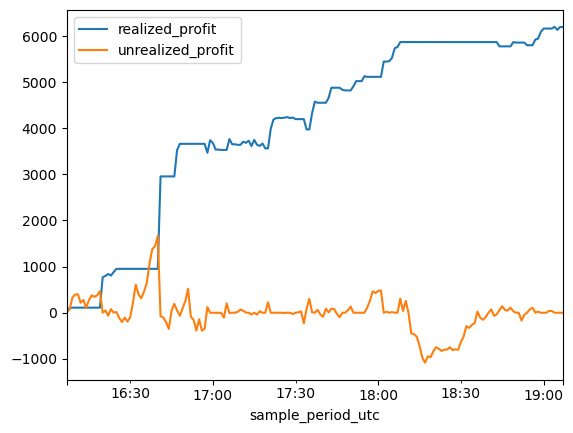

In [16]:
_ = leg_0[['realized_profit','unrealized_profit']].plot()

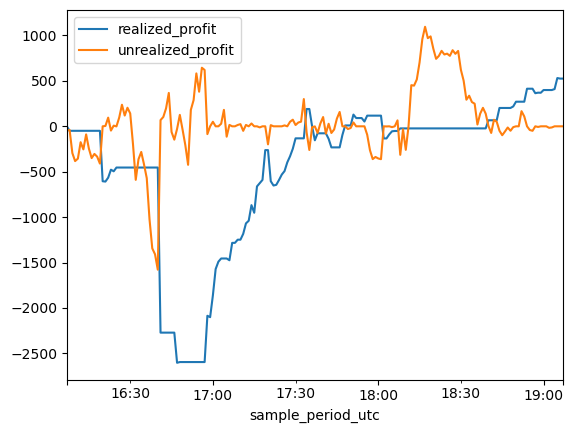

In [17]:
_ = leg_1[['realized_profit','unrealized_profit']].plot()

But we really only care about the combined profit

In [18]:
pnl_0 = leg_0.realized_profit + leg_0.unrealized_profit
pnl_1 = leg_1.realized_profit + leg_1.unrealized_profit
pnl = pnl_0 + pnl_1

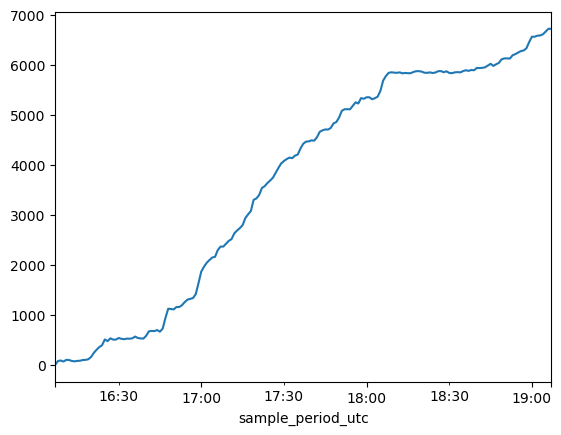

In [19]:
_ = pnl.plot()

... and of course, this is not a realistic simulation because we need to take into account the exchange fees which are directly proportional to the volume

The fee structure will normally depend on your specific tier and you must therefore use the volume and make your own adjustments to the profit shown in the previous step. You have enough information to achieve this:

In [20]:
vol_0 = leg_0.buy_volume + leg_0.sell_volume
vol_1 = leg_1.buy_volume + leg_1.sell_volume
vol = vol_0 + vol_1

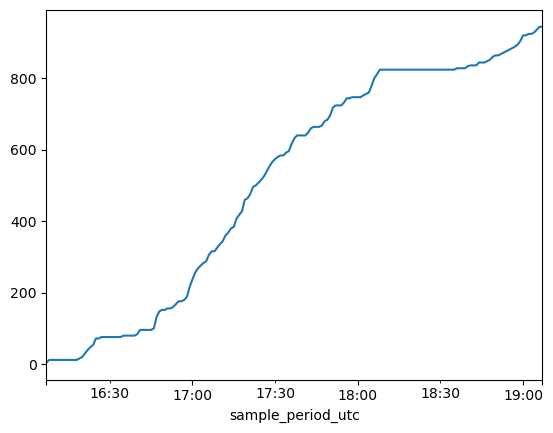

In [21]:
_ = vol.plot()

We can also look at average profit / volume (which could then be compared to the actual fees)

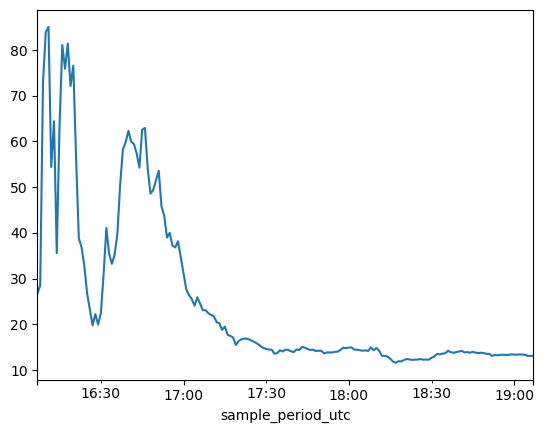

In [22]:
_ = (pnl_0 / vol_0).plot()

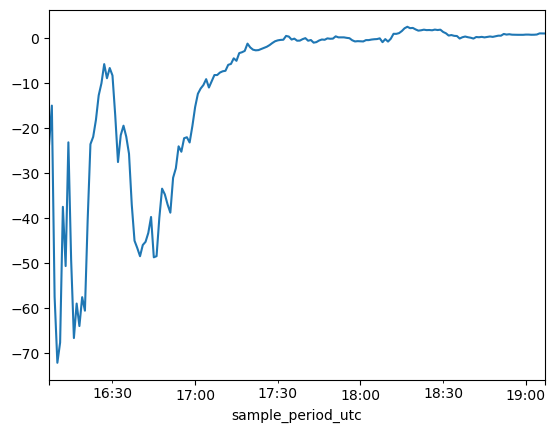

In [23]:
_ = (pnl_1 / vol_1).plot()

Let's look at the underlying prices.

Note that these are the best market prices from **last** updates for each sample period.

In [24]:
mid_0 = (leg_0.best_bid_price + leg_0.best_ask_price) / 2
mid_1 = (leg_1.best_bid_price + leg_1.best_ask_price) / 2

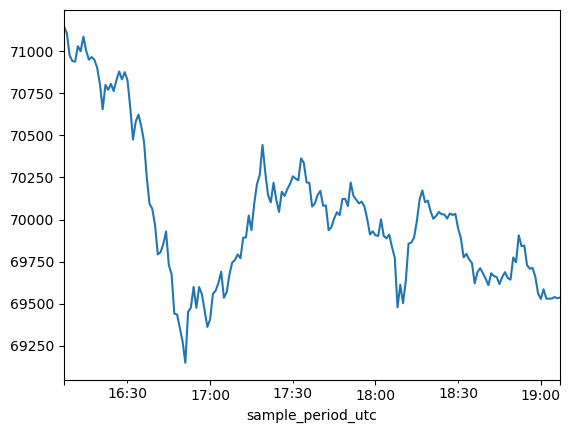

In [25]:
_ = mid_0.plot()

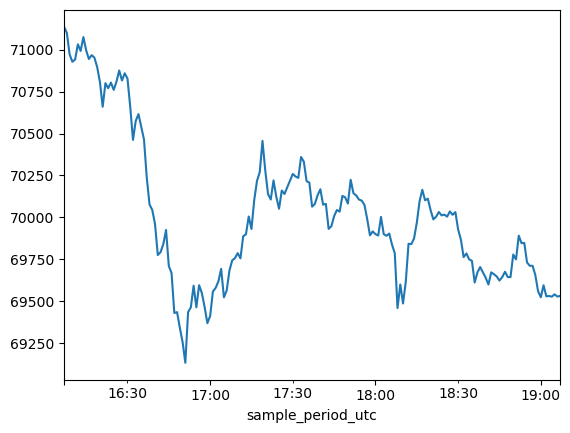

In [26]:
_ = mid_1.plot()

The strategy uses the spread for positioning

In [27]:
spread = mid_0 - mid_1

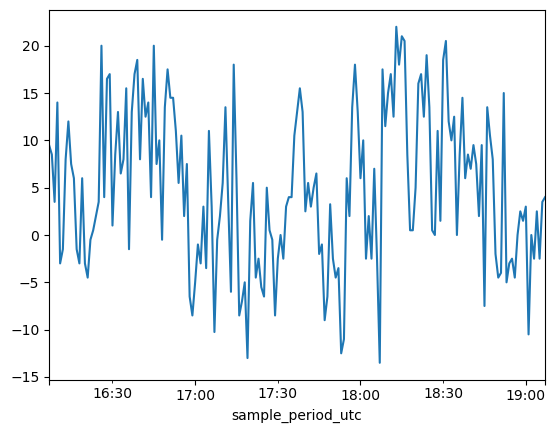

In [28]:
_ = spread.plot()

This strategy uses the first leg (index 0) as the basis for scaling other legs.

There are some complications making it a little difficult to demonstrate positions

* The strategy works with a target positions.
* There is a simulated latency such that each leg takes some time to fill.
* A limit order may be aggressive or passive depending on the price chosen by the strategy and the latency to the market.
* The strategy may change the aggressiveness of a limit order depending on what happens with the orders from other legs.

In [29]:
pos_0 = leg_0.position

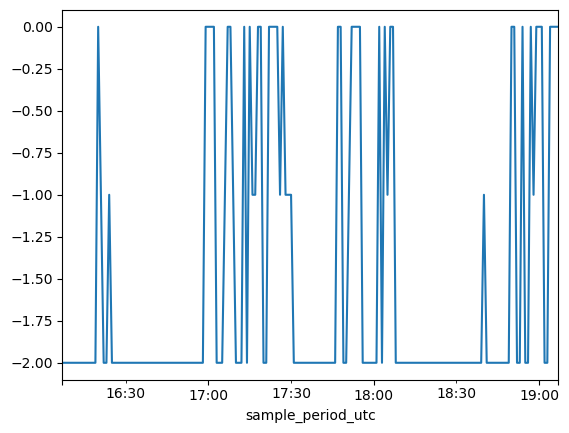

In [30]:
_ = pos_0.plot()

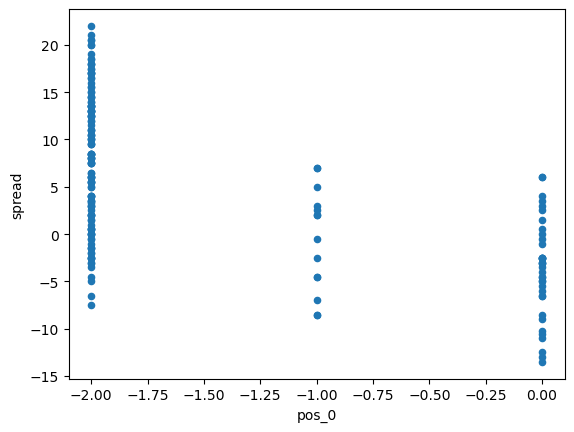

In [31]:
tmp = pd.concat([spread, pos_0], axis=1)
tmp.columns=['spread','pos_0']
_ = tmp.plot.scatter(x='pos_0',y='spread')

#### Report: OrderUpdate

In [32]:
order_update = get_report("order_update")

In [33]:
list(order_update.index.names)

['source', 'exchange', 'symbol', 'account', 'order_id', 'sending_time_utc']

In [34]:
list(order_update.columns.values)

['side',
 'create_time_utc',
 'update_time_utc',
 'order_status',
 'quantity',
 'price',
 'remaining_quantity',
 'traded_quantity',
 'average_traded_price']

In [35]:
order_update

side  \
source exchange symbol        account order_id sending_time_utc                
0      deribit  BTC-PERPETUAL A1      1001     2024-11-01 16:07:37.861  SELL   
                                      1003     2024-11-01 16:07:46.012  SELL   
                                      1005     2024-11-01 16:08:01.291   BUY   
                                      1007     2024-11-01 16:08:11.628   BUY   
                                      1009     2024-11-01 16:08:13.226  SELL   
...                                                                      ...   
1      bybit    BTCUSD        A1      1936     2024-11-01 19:05:36.030  SELL   
                                      1938     2024-11-01 19:06:03.210   BUY   
                                      1940     2024-11-01 19:06:04.530   BUY   
                                      1942     2024-11-01 19:06:11.890  SELL   
                                      1944     2024-11-01 19:06:12.310  SELL   

                                                                               create_time_utc  \
source exchange symbol        account order_id sending_time_utc                                  
0      deribit  BTC-PERPETUAL A1      1001     2024-11-01 16:07:37.861 2024-11-01 16:07:37.861   
                                      1003     2024-11-01 16:07:46.012 2024-11-01 16:07:46.012   
                                      1005     2024-11-01 16:08:01.291 2024-11-01 16:08:01.291   
                                      1007     2024-11-01 16:08:11.628 2024-11-01 16:08:11.628   
                                      1009     2024-11-01 16:08:13.226 2024-11-01 16:08:13.226   
...                                                                                        ...   
1      bybit    BTCUSD        A1      1936     2024-11-01 19:05:36.030 2024-11-01 19:05:36.030   
                                      1938     2024-11-01 19:06:03.210 2024-11-01 19:06:03.210   
                                      1940     2024-11-01 19:06:04.530 2024-11-01 19:06:04.530   
                                      1942     2024-11-01 19:06:11.890 2024-11-01 19:06:11.890   
                                      1944     2024-11-01 19:06:12.310 2024-11-01 19:06:12.310   

                                                                               update_time_utc  \
source exchange symbol        account order_id sending_time_utc                                  
0      deribit  BTC-PERPETUAL A1      1001     2024-11-01 16:07:37.861 2024-11-01 16:07:37.861   
                                      1003     2024-11-01 16:07:46.012 2024-11-01 16:07:46.012   
                                      1005     2024-11-01 16:08:01.291 2024-11-01 16:08:01.291   
                                      1007     2024-11-01 16:08:11.628 2024-11-01 16:08:11.628   
                                      1009     2024-11-01 16:08:13.226 2024-11-01 16:08:13.226   
...                                                                                        ...   
1      bybit    BTCUSD        A1      1936     2024-11-01 19:05:36.030 2024-11-01 19:05:36.030   
                                      1938     2024-11-01 19:06:03.210 2024-11-01 19:06:03.210   
                                      1940     2024-11-01 19:06:04.530 2024-11-01 19:06:04.530   
                                      1942     2024-11-01 19:06:11.890 2024-11-01 19:06:11.890   
                                      1944     2024-11-01 19:06:12.310 2024-11-01 19:06:12.310   

                                                                       order_status  \
source exchange symbol        account order_id sending_time_utc                       
0      deribit  BTC-PERPETUAL A1      1001     2024-11-01 16:07:37.861    COMPLETED   
                                      1003     2024-11-01 16:07:46.012    COMPLETED   
                                      1005     2024-11-01 16:08:01.291    COMPLETED   
                                      1007    

#### Report: TradeUpdate

In [36]:
trade_update = get_report("trade_update")

In [37]:
list(trade_update.index.names)

['source',
 'exchange',
 'symbol',
 'account',
 'order_id',
 'exchange_time_utc',
 'external_trade_id']

In [38]:
list(trade_update.columns.values)

['side',
 'create_time_utc',
 'update_time_utc',
 'quantity',
 'price',
 'liquidity']

In [39]:
trade_update

side  \
source exchange symbol        account order_id exchange_time_utc       external_trade_id         
0      deribit  BTC-PERPETUAL A1      1001     2024-11-01 16:07:37.861 trd-1              SELL   
                                      1003     2024-11-01 16:07:46.012 trd-3              SELL   
                                      1005     2024-11-01 16:08:01.291 trd-5               BUY   
                                      1007     2024-11-01 16:08:11.628 trd-7               BUY   
                                      1009     2024-11-01 16:08:13.226 trd-9              SELL   
...                                                                                        ...   
1      bybit    BTCUSD        A1      1936     2024-11-01 19:05:36.030 trd-936            SELL   
                                      1938     2024-11-01 19:06:03.210 trd-938             BUY   
                                      1940     2024-11-01 19:06:04.530 trd-939             BUY   
                                      1942     2024-11-01 19:06:11.890 trd-942            SELL   
                                      1944     2024-11-01 19:06:12.310 trd-944            SELL   

                                                                                                 create_time_utc  \
source exchange symbol        account order_id exchange_time_utc       external_trade_id                           
0      deribit  BTC-PERPETUAL A1      1001     2024-11-01 16:07:37.861 trd-1             2024-11-01 16:07:37.861   
                                      1003     2024-11-01 16:07:46.012 trd-3             2024-11-01 16:07:46.012   
                                      1005     2024-11-01 16:08:01.291 trd-5             2024-11-01 16:08:01.291   
                                      1007     2024-11-01 16:08:11.628 trd-7             2024-11-01 16:08:11.628   
                                      1009     2024-11-01 16:08:13.226 trd-9             2024-11-01 16:08:13.226   
...                                                                                                          ...   
1      bybit    BTCUSD        A1      1936     2024-11-01 19:05:36.030 trd-936           2024-11-01 19:05:36.030   
                                      1938     2024-11-01 19:06:03.210 trd-938           2024-11-01 19:06:03.210   
                                      1940     2024-11-01 19:06:04.530 trd-939           2024-11-01 19:06:04.530   
                                      1942     2024-11-01 19:06:11.890 trd-942           2024-11-01 19:06:11.890   
                                      1944     2024-11-01 19:06:12.310 trd-944           2024-11-01 19:06:12.310   

                                                                                                 update_time_utc  \
source exchange symbol        account order_id exchange_time_utc       external_trade_id                           
0      deribit  BTC-PERPETUAL A1      1001     2024-11-01 16:07:37.861 trd-1             2024-11-01 16:07:37.861   
                                      1003     2024-11-01 16:07:46.012 trd-3             2024-11-01 16:07:46.012   
                                      1005     2024-11-01 16:08:01.291 trd-5             2024-11-01 16:08:01.291   
                                      1007     2024-11-01 16:08:11.628 trd-7             2024-11-01 16:08:11.628   
                                      1009     2024-11-01 16:08:13.226 trd-9             2024-11-01 16:08:13.226   
...                                                                                                          ...   
1      bybit    BTCUSD        A1      1936     2024-11-01 19:05:36.030 trd-936           2024-11-01 19:05:36.030   
                                      1938     2024-11-01 19:06:03.210 trd-938           2024-11-01 19:06:03.210   
                                      1940     2024-11-01 19:06:04.530 trd-939           2024-11-01 19:06:04.530   
                              

## Summary

We have demonstrated how to use the simulator and how to inspect results generated by the reporter.

## Links

* [Roq GmbH (website)](https://roq-trading.com/)                                 
* [Contact (email)](mailto:info@roq-trading.com)                      
* [Documentation](https://roq-trading.com/docs/)                      
* [Releases](https://roq-trading.com/docs/releases/)                      
* [Gateways](https://roq-trading.com/docs/introduction/gateways/)                      
* [Samples](https://github.com/roq-trading/roq-cpp-samples/)                      
* [Roadmap](https://roq-trading.com/docs/introduction/roadmap/)                      
* [Pricing](https://roq-trading.com/#pricing)                      
* [LinkedIn](https://www.linkedin.com/company/35447832/)                      
* [Telegram](https://t.me/roq_trading/)

## License

MIT License                                 

Copyright (c) 2017-2024, Hans Erik Thrane                      

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.